# SRGAN

## Import TensorFlow and other libraries

In [166]:
from __future__ import absolute_import, division, print_function, unicode_literals

# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
import tensorflow_datasets as tfds


import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# utils

In [342]:
# Bicubic Downsample For Oxford Dogs
def bicubic_kernel(x, a=-0.5):
  """https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html#bicubic"""
  if abs(x) <= 1:
    return (a + 2)*abs(x)**3 - (a + 3)*abs(x)**2 + 1
  elif 1 < abs(x) and abs(x) < 2:
    return a*abs(x)**3 - 5*a*abs(x)**2 + 8*a*abs(x) - 4*a 
  else:
    return 0

def build_filter(factor):
  size = factor*4
  k = np.zeros((size))
  for i in range(size):
    x = (1/factor)*(i- np.floor(size/2) +0.5)
    k[i] = bicubic_kernel(x)
  k = k / np.sum(k)
  # make 2d
  k = np.outer(k, k.T)
  k = tf.constant(k, dtype=tf.float32, shape=(size, size, 1, 1))
  return tf.concat([k, k, k], axis=2)

def apply_bicubic_downsample(x, filter, factor):
  """Downsample x by a factor of factor, using the filter built by build_filter()
  x: a rank 4 tensor with format NHWC
  filter: from build_filter(factor)
  factor: downsampling factor (ex: factor=2 means the output size is (h/2, w/2))
  """
  # using padding calculations from https://www.tensorflow.org/api_guides/python/nn#Convolution
  filter_height = factor*4
  filter_width = factor*4
  strides = factor
  pad_along_height = max(filter_height - strides, 0)
  pad_along_width = max(filter_width - strides, 0)
  # compute actual padding values for each side
  pad_top = pad_along_height // 2
  pad_bottom = pad_along_height - pad_top
  pad_left = pad_along_width // 2
  pad_right = pad_along_width - pad_left
  # apply mirror padding
  x = tf.pad(x, [[0,0], [pad_top,pad_bottom], [pad_left,pad_right], [0,0]], mode='REFLECT')
  # downsampling performed by strided conv
  x = tf.nn.depthwise_conv2d(x, filter=filter, strides=[1,strides,strides,1], padding='VALID')
  return x

# normalize
# def normalize(image):
#     image = tf.cast(image, dtype=tf.float32)
#     return (image-tf.math.reduce_min(image))/(tf.math.reduce_max(image)-tf.math.reduce_min(image))

In [343]:
inp = np.ones([224, 224, 3], dtype=np.float32)
k = build_filter(factor=4)
down_result = apply_bicubic_downsample(tf.expand_dims(inp, 0), filter=k, factor=4)
#down_result = down_model(tf.expand_dims(inp, 0))
print(tf.expand_dims(inp, 0).shape)
print (down_result.shape)

(1, 224, 224, 3)
(1, 56, 56, 3)


## Load the dataset

In [344]:
def pickup_image(data_dict):
  real_image = data_dict['image']
  real_image = tf.cast(real_image, tf.float32)
  return real_image

In [345]:
def make_lr_sr_pair(real_image, downsampling_factor=4):
  k = build_filter(factor=downsampling_factor)
  lr = apply_bicubic_downsample(real_image, filter=k, factor=4)
  sr = real_image
  return lr, sr

In [346]:
def load_image(data):
    real_image = pickup_image(data)
    real_image = tf.expand_dims(real_image, 0)
    lr, sr = make_lr_sr_pair(real_image)
    lr = lr[0]
    sr = sr[0]
    return lr, sr

In [347]:
ds = tfds.load('oxford_iiit_pet')
train_dataset = ds['train'].map(load_image)
test_dataset = ds['test'].map(load_image)

In [348]:
for inp, re in train_dataset: break

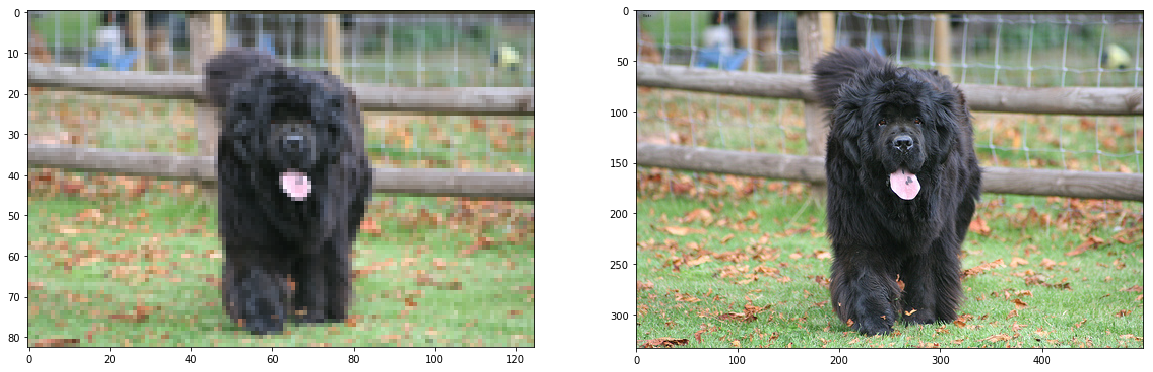

In [349]:
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(inp/255.0)
plt.subplot(1,2,2)
plt.imshow(re/255.0)
plt.show()

# data augmentation

In [350]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image


def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]


# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

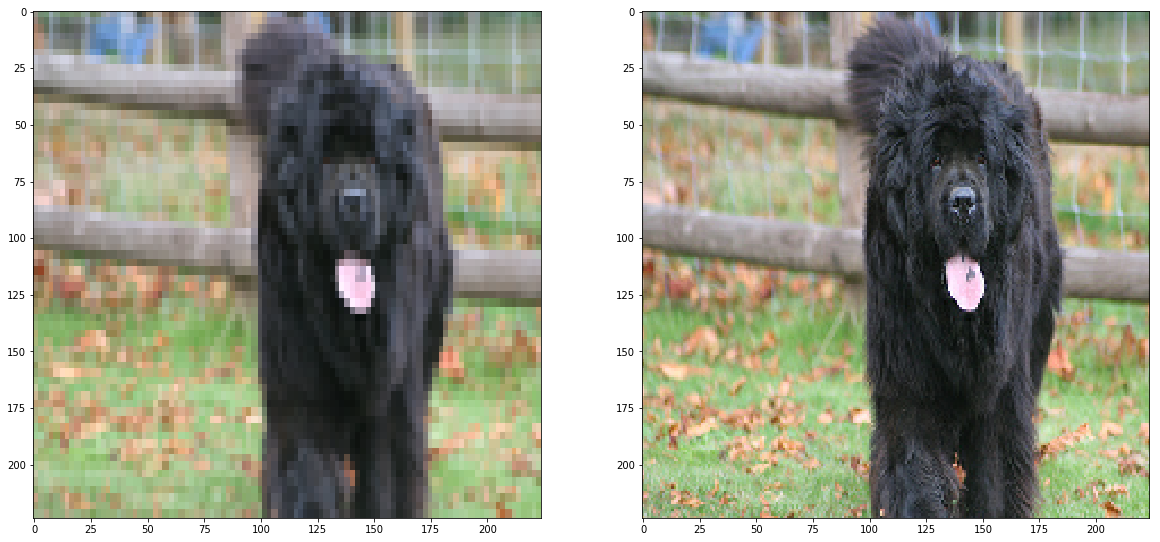

In [351]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

plt.figure(figsize=(20, 20))

rj_inp, rj_re = random_jitter(inp, re)
plt.subplot(1, 2, 1)
plt.imshow(rj_inp/255.0)
plt.subplot(1, 2, 2)
plt.imshow(rj_re/255.0)
plt.show()

## Input Pipeline

In [352]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 224
IMG_HEIGHT = 224
D_WIDTH = 56
D_HEIGHT = 56

In [353]:
def load_image_train(data_dict):
  input_image, real_image = load_image(data_dict)
  
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  
  input_image = tf.image.resize(input_image, [D_HEIGHT, D_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

def load_image_test(data_dict):
  input_image, real_image = load_image(data_dict)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  input_image = tf.image.resize(input_image, [D_HEIGHT, D_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


  return input_image, real_image

In [354]:
ds = tfds.load('oxford_iiit_pet')
train_dataset = ds['train']
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [355]:
test_dataset = ds['test']
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [356]:
for inp, re in train_dataset: break

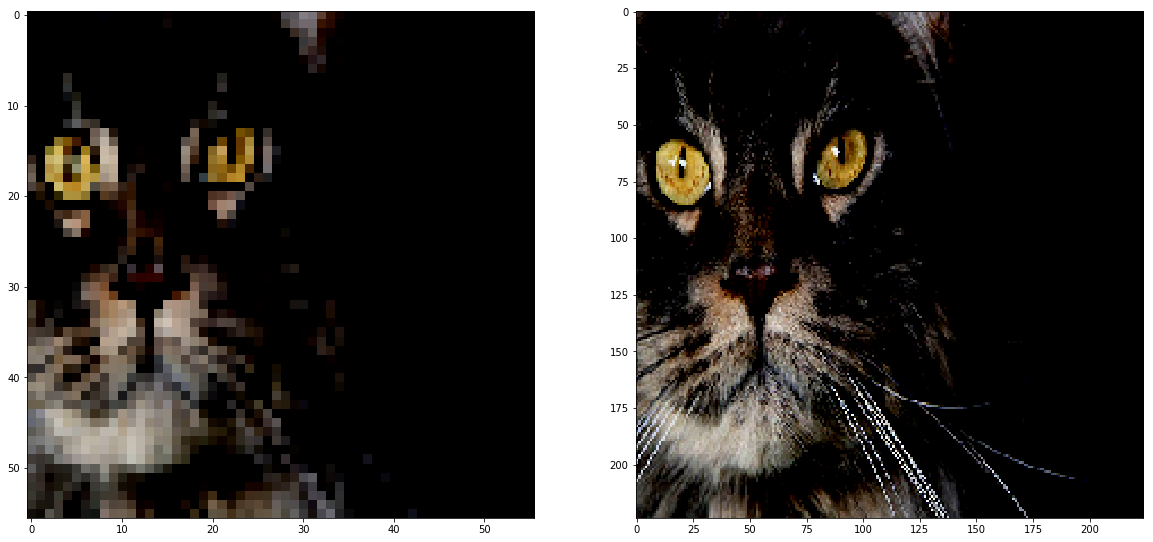

In [357]:
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(inp[0])
plt.subplot(1,2,2)
plt.imshow(re[0])
plt.show()

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [392]:
class Generator(tf.keras.Model):
  """SRResnet
  """
  def __init__(self):
    super(Generator, self).__init__(name='Generator')
    
    # k9n64s1
    self.conv1 = tf.keras.layers.Conv2D(64, 9, 1, padding='same')
    self.prelu1 = tf.keras.layers.PReLU(alpha_initializer='zeros')
    
    # B residual blocks
    # conv2_1, k3n64s1
    self.conv21a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn21a = tf.keras.layers.BatchNormalization()
    self.prelu21a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv21b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn21b = tf.keras.layers.BatchNormalization()
    
    self.x21_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x21 = tf.keras.layers.BatchNormalization()

     
    # conv2_2, k3n64s1
    self.conv22a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn22a = tf.keras.layers.BatchNormalization()
    self.prelu22a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv22b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn22b = tf.keras.layers.BatchNormalization()
    
    self.x22_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x22 = tf.keras.layers.BatchNormalization()

    # conv2_3, k3n64s1
    self.conv23a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn23a = tf.keras.layers.BatchNormalization()
    self.prelu23a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv23b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn23b = tf.keras.layers.BatchNormalization()
    
    self.x23_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x23 = tf.keras.layers.BatchNormalization()


    # conv2_4, k3n64s1
    self.conv24a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn24a = tf.keras.layers.BatchNormalization()
    self.prelu24a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv24b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn24b = tf.keras.layers.BatchNormalization()
    
    self.x24_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x24 = tf.keras.layers.BatchNormalization()


    # conv2_5, k3n64s1 -- end of B residual block
    self.conv25a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn25a = tf.keras.layers.BatchNormalization()
    self.prelu25a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv25b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn25b = tf.keras.layers.BatchNormalization()
    
    self.x25_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x25 = tf.keras.layers.BatchNormalization()


    # conv3, k3n64s1
    self.conv3 = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.x3_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x3 = tf.keras.layers.BatchNormalization()

    # conv4_1, k3n256s1
    self.conv41 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.prelu41 = tf.keras.layers.PReLU(alpha_initializer='zeros')
    # conv4_2
    self.conv42 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.prelu42 = tf.keras.layers.PReLU(alpha_initializer='zeros')

    # conv5, k9n3s1
    self.conv5 = tf.keras.layers.Conv2D(3, 9, 1, padding='same')
    

  def call(self, input_tensor, training=False):
    input_tensor = self.conv1(input_tensor)
    input_tensor = self.prelu1(input_tensor)
    
     # B residual blocks
    # conv2_1, k3n64s1
    x = self.conv21a(input_tensor)
    x = self.bn21a(x)
    x = self.prelu21a(x)                          
    x = self.conv21b(x)                         
    x = self.bn21b(x)                 
    x_append = self.x21_append(input_tensor)
    x += x_append                   
    x21 = self.bn_x21(x)                 

     
    # conv2_2, k3n64s1
    x = self.conv22a(x21)          
    x = self.bn22a(x)               
    x = self.prelu22a(x)                 
    x = self.conv22b(x)          
    x = self.bn22b(x)                  
    x_append = self.x22_append(x21)
    x += x_append                   
    x22 = self.bn_x22(x)                 

    # conv2_3, k3n64s1
    x = self.conv23a(x22)         
    x = self.bn23a(x)                
    x = self.prelu23a(x)              
    x = self.conv23b(x)          
    x = self.bn23b(x)                
    
    x_append = self.x23_append(x22)
    x += x_append           
    x23 = self.bn_x23(x)                


    # conv2_4, k3n64s1
    x = self.conv24a(x23)           
    x = self.bn24a(x)                
    x = self.prelu24a(x)             
    x = self.conv24b(x)          
    x = self.bn24b(x)                
    
    x_append = self.x24_append(x23)
    x += x_append              
    x24 = self.bn_x24(x)                


    # conv2_5, k3n64s1 -- end of B residual block
    x = self.conv25a(x24)           
    x = self.bn25a(x)                
    x = self.prelu25a(x)             
    x = self.conv25b(x)          
    x = self.bn25b(x)                
    
    x_append = self.x25_append(x24)
    x += x_append              
    x25 = self.bn_x25(x)                


    # conv3, k3n64s1
    x = self.conv3(x25)        
    x = self.bn3(x)                
    x_append = self.x3_append(input_tensor)
    x += x_append
    x = self.bn_x3(x)      


    # conv4_1, k3n256s1
    x = self.conv41(x) 
    x = tf.nn.depth_to_space(x, block_size=2)               
    x = self.prelu41(x)             
    # conv4_2
    x = self.conv42(x)
    x = tf.nn.depth_to_space(x, block_size=2)               
    x = self.prelu42(x)             

    # conv5, k9n3s1
    x = self.conv5(x)         
    return x

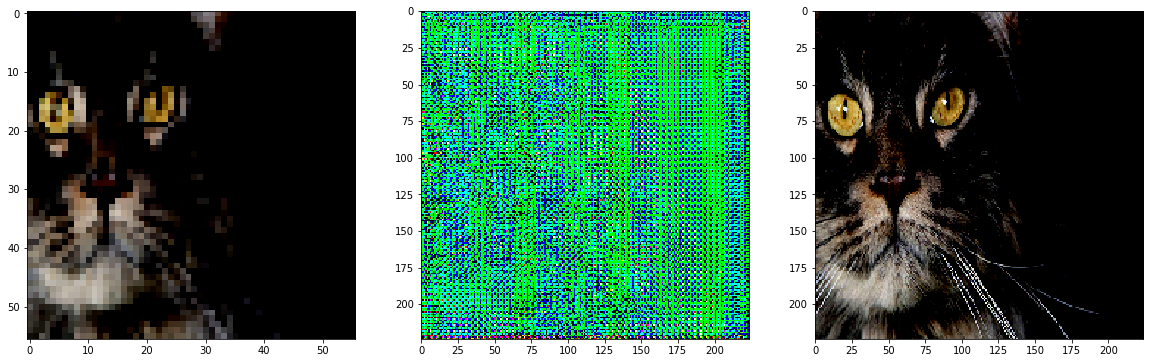

In [359]:
generator = Generator()


gen_output = generator(inp, training=False)

fig,ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(inp[0])
ax[1].imshow(gen_output[0]*255)
ax[2].imshow(re[0])


plt.show()

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [403]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__(name='Discriminator')
    
    # k3n64s1
    self.conv1 = tf.keras.layers.Conv2D(64, 3, 1, padding='same', name='conv1')
    self.leakyrelu1 = tf.keras.layers.LeakyReLU(alpha=0.2)
    
    #  blocks
    # conv2_1, k3n64s2
    self.conv21 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', name='conv21')
    self.bn21 = tf.keras.layers.BatchNormalization()
    self.leakyrelu21 = tf.keras.layers.LeakyReLU(alpha=0.2)
     
    # conv2_2, k3n128s1
    self.conv22 = tf.keras.layers.Conv2D(128, 3, 1, padding='same')
    self.bn22 = tf.keras.layers.BatchNormalization()
    self.leakyrelu22 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_3, k3n128s2
    self.conv23 = tf.keras.layers.Conv2D(128, 3, 2, padding='same')
    self.bn23 = tf.keras.layers.BatchNormalization()
    self.leakyrelu23 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_4, k3n256s1
    self.conv24 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.bn24 = tf.keras.layers.BatchNormalization()
    self.leakyrelu24 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_5, k3n256s2
    self.conv25 = tf.keras.layers.Conv2D(256, 3, 2, padding='same')
    self.bn25 = tf.keras.layers.BatchNormalization()
    self.leakyrelu25 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_6, k3n512s1
    self.conv26 = tf.keras.layers.Conv2D(512, 3, 1, padding='same')
    self.bn26 = tf.keras.layers.BatchNormalization()
    self.leakyrelu26 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_7, k3n512s2 -- end of B residual block
    self.conv27 = tf.keras.layers.Conv2D(512, 3, 2, padding='same')
    self.bn27 = tf.keras.layers.BatchNormalization()
    self.leakyrelu27 = tf.keras.layers.LeakyReLU(alpha=0.2)

    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(1024, name='d_den_1')
    self.leakyrelu3 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid', name='d_den_2')
    

  def call(self, input_tensor, training=False):
    input_tensor = self.conv1(input_tensor)
    input_tensor = self.leakyrelu1(input_tensor)
    
    # conv2_1, k3n64s2
    x = self.conv21(input_tensor)
    x = self.bn21(x)
    x = self.leakyrelu21(x)                          
     
    # conv2_2, k3n128s1
    x = self.conv22(x)          
    x = self.bn22(x)               
    x = self.leakyrelu22(x)                        

    # conv2_3, k3n128s2
    x = self.conv23(x)         
    x = self.bn23(x)                
    x = self.leakyrelu23(x)                         

    # conv2_4, k3n256s1
    x = self.conv24(x)           
    x = self.bn24(x)                
    x = self.leakyrelu24(x)            

    # conv2_5, k3n256s2
    x = self.conv25(x)           
    x = self.bn25(x)                
    x = self.leakyrelu25(x)            

    # conv2_6, k3n512s1
    x = self.conv25(x)           
    x = self.bn25(x)                
    x = self.leakyrelu25(x)            

    # conv2_7, k3n512s2 -- end of B residual block
    x = self.conv25(x)           
    x = self.bn25(x)                
    x = self.leakyrelu25(x)            

    x = self.flatten(x)
    x = self.dense1(x)
    x = self.leakyrelu3(x)
    x = self.dense2(x)

    return x

In [405]:
discriminator = Discriminator()
disc_out = discriminator(tf.ones_like(gen_output), training=False)
print(disc_out)
disc_out = discriminator(tf.zeros_like(gen_output), training=False)
print(disc_out)
disc_out = discriminator(gen_output, training=False)
print(disc_out)
disc_out = discriminator(re, training=False)
print(disc_out)
disc_out = discriminator(tf.image.resize(inp, [IMG_HEIGHT, IMG_WIDTH]), training=False)
print(disc_out)

tf.Tensor([[0.49852854]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49984568]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49849477]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4983756]], shape=(1, 1), dtype=float32)


To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [292]:
LAMBDA = 100

In [290]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [406]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [407]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [408]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints (Object-based saving)

In [409]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](images/dis.png)


---


![Generator Update Image](images/gen.png)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [410]:
EPOCHS = 150

In [415]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [416]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator(target, training=True)
    disc_generated_output = discriminator(gen_output, training=True)
    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [417]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # Train
    for input_image, target in train_ds:
      train_step(input_image, target)

    clear_output(wait=True)
    # Test on the same image so that the progress of the model can be 
    # easily seen.
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

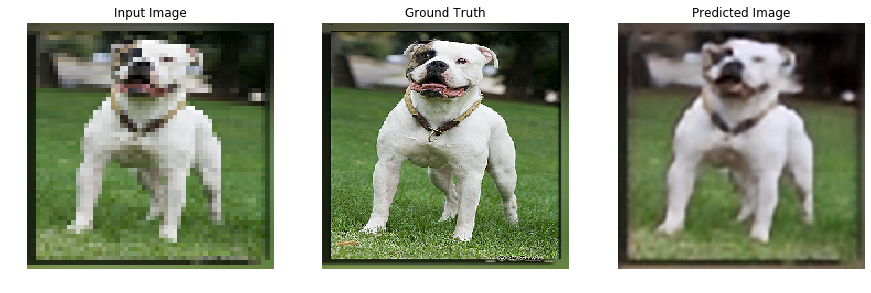

Time taken for epoch 2 is 473.0200819969177 sec



KeyboardInterrupt: 

In [418]:
fit(train_dataset, EPOCHS, test_dataset)

## Restore the latest checkpoint and test

In [36]:
!ls {checkpoint_dir}

checkpoint		    ckpt-4.data-00001-of-00002
ckpt-1.data-00000-of-00002  ckpt-4.index
ckpt-1.data-00001-of-00002  ckpt-5.data-00000-of-00002
ckpt-1.index		    ckpt-5.data-00001-of-00002
ckpt-2.data-00000-of-00002  ckpt-5.index
ckpt-2.data-00001-of-00002  ckpt-6.data-00000-of-00002
ckpt-2.index		    ckpt-6.data-00001-of-00002
ckpt-3.data-00000-of-00002  ckpt-6.index
ckpt-3.data-00001-of-00002  ckpt-7.data-00000-of-00002
ckpt-3.index		    ckpt-7.data-00001-of-00002
ckpt-4.data-00000-of-00002  ckpt-7.index


In [37]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

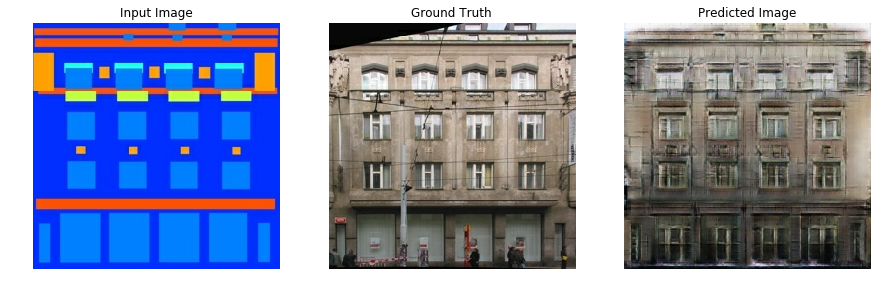

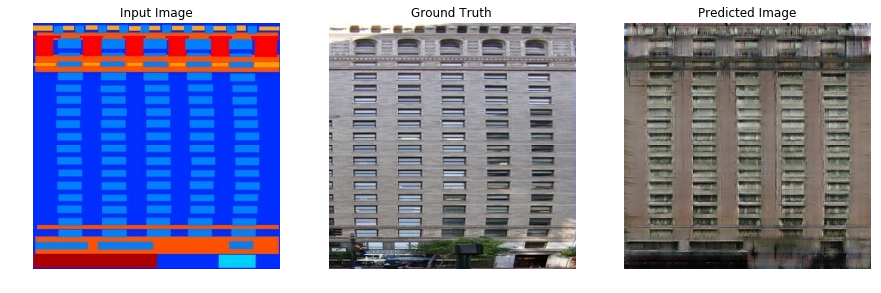

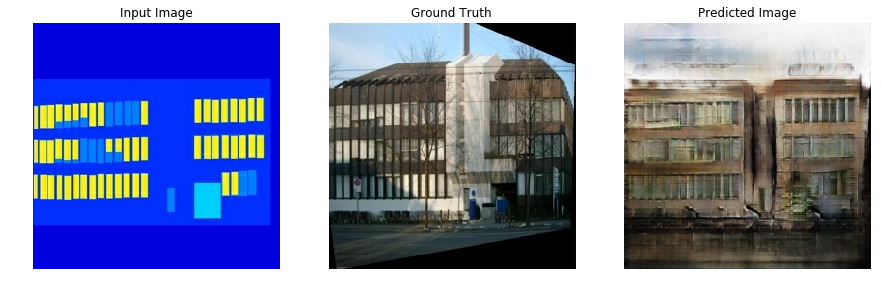

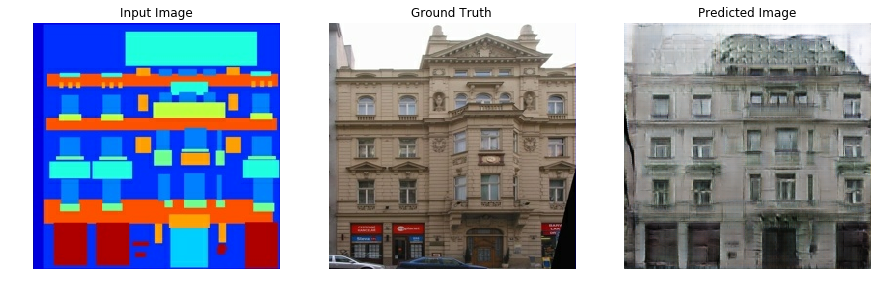

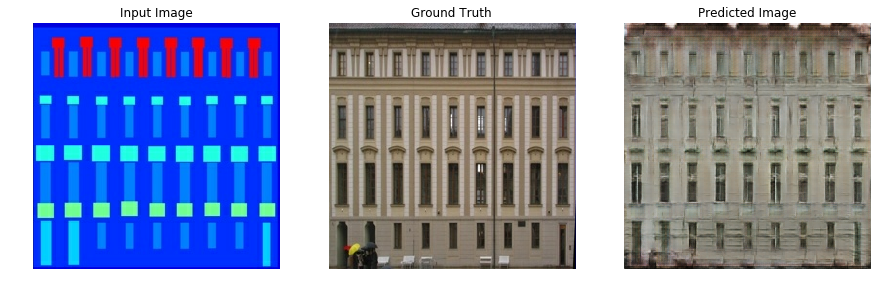

In [38]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)